#Field prediction using ResUnet

#Configuration

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-hl0_jrdi
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-hl0_jrdi
     |████████████████████████████████| 952kB 4.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=1af5daa10d85a256e6e12a7be27a2fa0b67a76032ed641c49a459df54fee58ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-yd08e1ze/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-0hfc7q_n
  Running command git clone -q https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-0hfc7q_n
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 2.9MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=750b15f94ccc155964b18604680796c8f4b41d6175876f98fc1a9f93c1d9763f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qphbdnwy/wheels/d6/18/c4/340b3ee7253119ec907ec8cf93bd2c572ee9a75eedb183b2f8
Successfully built segmentation-models


In [ ]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow import keras
import albumentations as A

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
import segmentation_models as sm

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


In [ ]:
# Kernel Configurations
save_model = True # save the model after training
train_dir = '' # directory of training images
pretrained_model_path = '' # path of pretrained model
model_save_path = '' # path of model to save
k_size = 3

img_w = 256 # resized weidth
img_h = 256 # resized height
epochs = 25
# batch size for training unet
batch_size = 5

#Input Data & Mask

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/Field-Prediction/zip/dataset.zip" -d "/content/drive/My Drive/Field-Prediction/output"

In [ ]:
import pathlib
dataset_path = '/content/drive/My Drive/Field-Prediction/output/dataset'
image_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/image')
mask_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/segmentation_mask')

'''
train_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/image/img')
train_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/segmentation_mask/img')
val_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/image/img')
val_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/segmentation_mask/img')
'''


"\ntrain_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/image/img')\ntrain_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/train/segmentation_mask/img')\nval_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/image/img')\nval_label_dir = pathlib.Path('/content/drive/My Drive/Field-Prediction/output/dataset/val/segmentation_mask/img')\n"

In [ ]:
image_count = len(list(image_dir.glob("*.png")))
print(image_count)



102


In [ ]:
image_id = os.listdir(image_dir)
print(image_id)


['10m_b2_natural color_003.png', '10m_b2_natural color_002.png', '10m_b2_natural color_004.png', '10m_b2_natural color_001.png', '10m_b2_natural color_005.png', '10m_b2_natural color_284.png', '10m_b2_natural color_307.png', '10m_b2_natural color_264.png', '10m_b2_natural color_265.png', '10m_b2_natural color_274.png', '10m_b2_natural color_261.png', '10m_b2_natural color_291.png', '10m_b2_natural color_311.png', '10m_b2_natural color_263.png', '10m_b2_natural color_271.png', '10m_b2_natural color_270.png', '10m_b2_natural color_287.png', '10m_b2_natural color_326.png', '10m_b2_natural color_268.png', '10m_b2_natural color_290.png', '10m_b2_natural color_324.png', '10m_b2_natural color_294.png', '10m_b2_natural color_281.png', '10m_b2_natural color_289.png', '10m_b2_natural color_305.png', '10m_b2_natural color_303.png', '10m_b2_natural color_313.png', '10m_b2_natural color_310.png', '10m_b2_natural color_286.png', '10m_b2_natural color_292.png', '10m_b2_natural color_262.png', '10m_b2

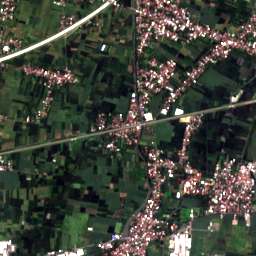

In [ ]:
gambar = list(image_dir.glob('*.png'))
PIL.Image.open(str(gambar[50]))

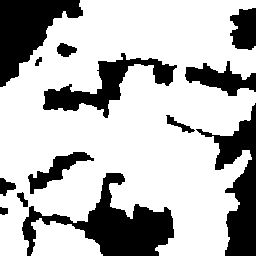

In [ ]:
mask_test = list(mask_dir.glob('*.png'))
PIL.Image.open(str(mask_test[50]))

#Data loader

##bechmark:
- https://www.kaggle.com/mukulkr/camvid-segmentation-using-unet/notebook
- kaggle ResUnet
- https://github.com/matterport/Mask_RCNN/blob/v2.1/samples/balloon/balloon.py
- https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/


##Bechmark 7: https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [ ]:
# classes for data loading and preprocessing
class Dataset:
    """    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
      """
    
    CLASSES = ['rumah','sawah']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis= -1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

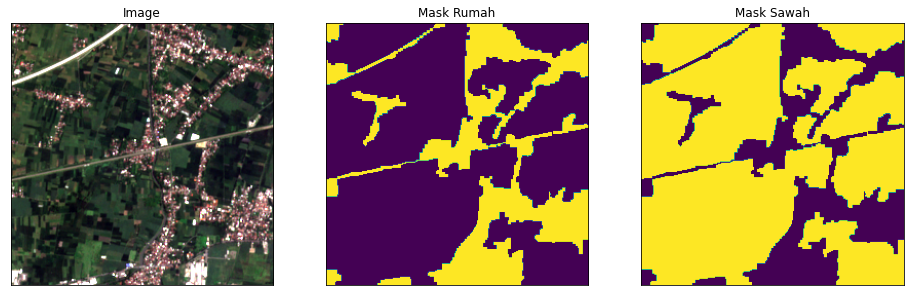

In [ ]:
dataset = Dataset(image_dir, mask_dir, classes=['rumah','sawah'])

image, mask = dataset[50] # get some sample
visualize(
    image=image, 
    mask_rumah=mask[...,0].squeeze(),
    mask_sawah=mask[...,2].squeeze()
)

#Data Augmentations

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask= round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image= preprocessing_fn()),
    ]
    return A.Compose(_transform)


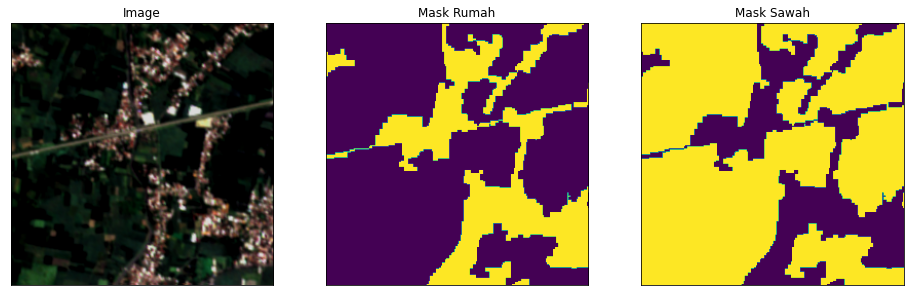

In [ ]:
# Lets look at data we have
dataset = Dataset(image_dir, mask_dir, classes=['rumah','sawah'], augmentation=get_training_augmentation())

image, mask = dataset[50] # get some sample
visualize(
    image=image, 
    mask_rumah=mask[...,0].squeeze(),
    mask_sawah=mask[...,2].squeeze()
)

#Model Architecture (ResUnet)

In [ ]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output
def residual_block(x, filters, kernel_size= k_size, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c


def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 1))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

#Loss Function

In [ ]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

#Compile & Run

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['sawah']
LR = 0.0001
EPOCHS = 40

#preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [ ]:
model = ResUNet(img_h=img_h, img_w=img_w)
optim = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=optim, loss=focal_tversky_loss, metrics=[tversky])

In [ ]:
# Dataset for train images
image_dataset = Dataset(
    image_dir, 
    mask_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation()
)

train_dataloader = Dataloder(image_dataset, batch_size=BATCH_SIZE, shuffle=True)

assert train_dataloader[0][0].shape == (BATCH_SIZE, img_h, img_w, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, img_h, img_w, n_classes)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, img_h, img_w, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, img_h, img_w, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
if load_pretrained_model:
    try:
        model.load_weights(pretrained_model_path)
        print('pre-trained model loaded!')
    except OSError:
        print('You need to run the model and load the trained model')

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [ ]:
#history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=epochs, verbose=1)

if save_model:
    model.save(model_save_path)